# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add integration folder to current working path
sys.path.append(parent_directory+"/Src/integration")

# add utils folder to current working path
sys.path.append(parent_directory+"/Src/utils")

Wall time: 997 µs


# Steady ABC flow

In [2]:
%%time
import numpy as np
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/ABC_steady.mat')

U = mat_file['u'] 
V = mat_file['v'] 
W = mat_file['w'] 
x = mat_file['x'] 
y = mat_file['y'] 
z = mat_file['z']
time = np.array([0, 0])

Wall time: 108 ms


## Data/Parameters for Dynamical System

In [3]:
# Number of cores to be used for parallel computing
Ncores = 8

# Periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# steady/unsteady
bool_unsteady = False

## Compute Meshgrid
X, Y, Z = np.meshgrid(x, y, z)

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.linspace(0, 10, 100)#np.array([t_OECS])

# length of time-interval
lenT = time[-1]-time[0]

# domain boundaries
xmin = X[0, 0, 0]
xmax = X[0, -1,0]
ymin = Y[0, 0, 0]
ymax = Y[-1,0, 0]
zmin = Z[0, 0, 0]
zmax = Z[0, 0,-1]

# resolution of meshgrid (in degrees)
res_x = 100
res_y = 100
res_z = 100

x_domain = np.linspace(xmin, xmax, res_x, endpoint = True)
y_domain = np.linspace(ymin, ymax, res_y, endpoint = True)
z_domain = np.linspace(zmin, zmax, res_z, endpoint = True)

## Compute Meshgrid
X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain)

Wall time: 3 ms


## Velocity Interpolation

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
from ipynb.fs.defs.Interpolant import interpolant_steady

Interpolant = interpolant_steady(X, Y, Z, U, V, W)

Wall time: 61.9 ms


## Compute Trajectories

In [6]:
%%time
# function to compute trajectory 
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# package for progress bar
from tqdm.notebook import tqdm

# package for parallel computing
from joblib import Parallel, delayed

def parallel_integration(i):
    
    # define trajectories/velocities over Y,Z meshgrid
    trajectory_grid = np.zeros((X_domain.shape[1], X_domain.shape[2], len(time), 3))
    velocity_grid = np.zeros((X_domain.shape[1], X_domain.shape[2], len(time), 3))

    for j in range(Y_domain.shape[1]):
        
        for k in range(Z_domain.shape[2]):
            
            # only compute trajectories which are on the sides of the cube
            if k==0:
                
                x = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k]])
                
                trajectory, velocity = integration_dFdt(time, x, X, Y, Z, Interpolant, periodic, bool_unsteady)

                trajectory_grid[j, k, :,:] = trajectory.T
                velocity_grid[j, k,:, :] = velocity.T
                
    return trajectory_grid, velocity_grid

results_parallel = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_integration)(i) for i in tqdm(range(X_domain.shape[0]))))

# extract trajectory_grid and velocity_grid from results of parallel computation

trajectory_grid = results_parallel[:,0,:,:,:,:]
velocity_grid = results_parallel[:,1,:,:,:-1,:]

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 10min 44s


## Compute $ \mathrm{\overline{TRA}} $

In [9]:
from ipynb.fs.defs.TRA import _TRA

TRA = _TRA(lenT, velocity_grid, v0 = 0)

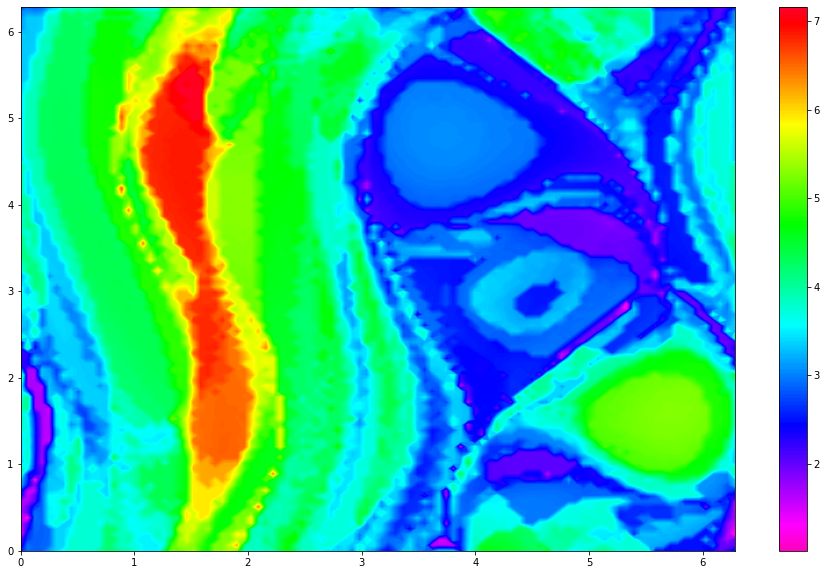

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
#ax.plot(velocity_grid[4, 0, 0, :, 0])
#ax.plot(velocity_grid[4, 0, 0, :, 1])
#ax.plot(velocity_grid[4, 0, 0, :, 2])
cax = ax.contourf(X_domain[:,:,0], Y_domain[:,:,0], TRA[:,:,0], levels = 600, cmap = "gist_rainbow_r")
plt.colorbar(cax, ticks = np.arange(1, 8, 1))
plt.show()

In [ ]:
# Import plotting packages 
import pyvista as pv
import matplotlib.pyplot as plt

# Controlling the text properties
sargs = dict(
    title_font_size=14,
    label_font_size=12,
    shadow=False,
    n_labels=5,
    italic=True,
    fmt="%.0f",
    height=0.25, 
    vertical=True, 
    position_x=0.05, 
    position_y=0.05
)

print('initializing 3D B field')
grid = pv.StructuredGrid(X_domain, Y_domain, Z_domain)
# Add the data values to the cell data
grid["ABC field magnitude"] = TRA.flatten()  # Flatten the array!
#grid["ABC field magnitude"] = np.linalg.norm(B, axis=1)
#grid["ABC field vectors"] = B
#grid.set_active_vectors("values")
#contours = grid.contour(20, scalars="ABC field magnitude")
#arrows = contours.glyph(orient="ABC field vectors", factor=50.0)

print('plotting')
p = pv.Plotter(notebook=1, shape=(1,1))
#p.background_color='white'
#p.window_size
cmap = plt.cm.get_cmap("viridis", 200)
p.add_mesh(grid, cmap=cmap, scalar_bar_args=sargs)
p.show_grid()

p.link_views()
p.view_isometric()
#p.disable()
p.show()

## Rate of Strain tensor

In [ ]:
%%time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from ipynb.fs.defs.eigen import eigen_S

# Define Rate of Strain over meshgrid (Ny, Nx, Nz, 3, 3)
S = np.zeros((X_domain.shape[0], X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan

# Define grid spacing
grid_spacing = 0.05

def parallel(i):
    
    S_ = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    s_ = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    e_ = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    
    for j in range(X_domain.shape[1]):
                
        for k in range(X_domain.shape[2]):
        
            x = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k]])
        
            spin_tensor = DS._spin_tensor(t_OECS, x, grid_spacing)
        
            # Compute rate of strain
            S_[j, k,:,:] = spin_tensor
            
    return S_

# Iterate over meshgrid
S = np.array(Parallel(n_jobs=DS.Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

## Eigenvalues/Eigenvectors of rate of strain tensor

In [ ]:
%%time
from ipynb.fs.defs.eigen import eigen_S

def parallel(i):

    s_ = np.zeros((X_domain.shape[1], X_domain.shape[2], 3))*np.nan
    e_ = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    
    for j in range(X_domain.shape[1]):
        
        for k in range(X_domain.shape[2]):
            
            # Compute eigenvalue of rate of strain tensor 
            s_[j, k, :], e_[j, k, :, :] = eigen_S(S[i, j, k,:,:])
            
    return s_, e_[:, :, 0, :], e_[:, :, 1, :], e_[:, :, 2, :]

# Iterate over meshgrid
res = np.array(Parallel(n_jobs=DS.Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

# Eigenvalues and eigenvectors of rate of strain tensor
s = res[:,0,:,:,:]
e1 = res[:,1,:,:,:]
e2 = res[:,2,:,:,:]
e3 = res[:,3,:,:,:]

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

cax = ax1.contourf(X_domain[:,:,0], Y_domain[:,:,0], s[0,:,:,0], levels = 600)
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.set_title(r'$s_1$')
plt.colorbar(cax, ax = ax1, ticks = np.arange(-.3, 0.1, 0.025))

cax = ax2.contourf(X_domain[:,:,0], Y_domain[:,:,0], s[0,:,:,1], levels = 600)
ax2.set_xlabel('x')
ax2.set_title(r'$s_2$')
plt.colorbar(cax, ax = ax2, ticks = np.arange(-.1, .1, 0.01))

cax = ax3.contourf(X_domain[:,:,0], Y_domain[:,:,0], s[0,:,:,2], levels = 600)
ax3.set_xlabel('x')
ax3.set_title(r'$s_3$')
plt.colorbar(cax, ax = ax3, ticks = np.arange(0, .35, 0.025))

plt.show()

## Interpolate Eigenvector-field

In [ ]:
%%time

# import RegularGridInterpolator from scipy
from scipy.interpolate import RegularGridInterpolator as RGI

# Interpolant e2x
interp_e2x = RGI((Y_domain[:,0, 0], X_domain[0,:,0], Z_domain[0,0,:]), e2[:,:,:,0])

# Interpolant e2y
interp_e2y = RGI((Y_domain[:,0, 0], X_domain[0,:,0], Z_domain[0,0,:]), e2[:,:,:,1])
                 
# Interpolant e2z
interp_e2z = RGI((Y_domain[:,0, 0], X_domain[0,:,0], Z_domain[0,0,:]), e2[:,:,:,2])

## Poincare map of $ \mathbf{x}' = \mathbf{e}_2(\mathbf{x})$ with $ z = 0 $

### Compute trajectories of $ \mathbf{x}' = \mathbf{e}_2(\mathbf{x})$ on plane $ z = 0 $

In [ ]:
from ipynb.fs.defs.RK4_tensorlines import _RK4_tensorlines
from ipynb.fs.defs.scaling_vectorfield import _scaling_vectorfield

# Define inital orientation from where to launch trajectories
xprime_init_orientation = np.array([0, 0, 1])

# Define vector field
vector_field = e2

iteration_array = np.linspace(0, 1, 100, endpoint = True)

# step-size for integration
ds = iteration_array[1]-iteration_array[0]

# Create array storing trajectory/velocity of particles launched from meshgrid
trajectory = np.zeros((X_domain.shape[0], X_domain.shape[1], Z_domain.shape[2], len(iteration_array), 3))*np.nan
velocity = np.zeros((X_domain.shape[0], X_domain.shape[1], Z_domain.shape[2], len(iteration_array), 3))*np.nan

def parallel(i):
    
    # Create array storing trajectory/velocity of particles launched from meshgrid
    trajectory = np.zeros((X_domain.shape[1], Z_domain.shape[2], len(iteration_array), 3))*np.nan
    velocity = np.zeros((X_domain.shape[1], Z_domain.shape[2], len(iteration_array), 3))*np.nan
    
    print("i: ", i)
    
    for j in range(0, X_domain.shape[1]):
        
        for k in range(Z_domain.shape[2]):
            
            if k == 0:

                # Initial condition
                x = np.array([Y_domain[i, j, k], X_domain[i, j, k], Z_domain[i, j, k]])
                
                # Initial orientation of vector
                x_prime =_scaling_vectorfield(X_domain, Y_domain, Z_domain, x, xprime_init_orientation, vector_field)
                
                print(x_prime)
                
                for iter in range(len(iteration_array)):
                        
                    trajectory[j, k, iter, :] = x
                    velocity[j, k, iter, :] = x_prime
            
                    x, x_prime = _RK4_tensorlines(X_domain, Y_domain, Z_domain, x, x_prime, ds, vector_field, Periodic)
                
    return trajectory, velocity

# Iterate over meshgrid
res = np.array(Parallel(n_jobs=DS.Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(0, X_domain.shape[0]))))

In [ ]:
trajectory_grid = res[:,0,:,:,:,:]
velocity_grid = res[:,1,:,:,:,:]

In [ ]:
from ipynb.fs.defs.TRA import _TRA

TRA = _TRA(velocity_grid.shape[-2], velocity_grid, v0 = 0)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes(projection = '3d')
x_traj = trajectory_grid[14, 10, 0, :, 0]
y_traj = trajectory_grid[14, 10, 0, :, 1]
z_traj = trajectory_grid[14, 10, 0, :, 2]
ax.plot(x_traj, y_traj, z_traj)
ax.scatter(x_traj[0], y_traj[0], z_traj[0], c = "r", marker = "^")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
F = lambda x, y, z: *2+ y**2+z**2

import pyvista as pv
import numpy as np
from numpy import mgrid
import matplotlib.pyplot as plt

# Controlling the text properties
sargs = dict(
    title_font_size=14,
    label_font_size=12,
    shadow=False,
    n_labels=5,
    italic=True,
    fmt="%.0f",
    height=0.25, 
    vertical=True, 
    position_x=0.05, 
    position_y=0.05
)

print('initializing 3D B field')
grid = pv.StructuredGrid(X_domain, Y_domain, Z_domain)
# Add the data values to the cell data
grid["ABC field magnitude"] = F(X_domain, Y_domain, Z_domain).flatten()  # Flatten the array!
#grid["ABC field magnitude"] = np.linalg.norm(B, axis=1)
#grid["ABC field vectors"] = B
#grid.set_active_vectors("values")
#contours = grid.contour(20, scalars="ABC field magnitude")
#arrows = contours.glyph(orient="ABC field vectors", factor=50.0)

print('plotting')
p = pv.Plotter(notebook=1, shape=(1,1))
#p.background_color='white'
#p.window_size
cmap = plt.cm.get_cmap("viridis", 200)
p.add_mesh(grid, cmap=cmap, scalar_bar_args=sargs)
p.show_grid()

p.link_views()
p.view_isometric()
#p.disable()
p.show()

In [ ]:
%%time
# function to compute trajectory 
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# package for progress bar
from tqdm.notebook import tqdm

# package for parallel computing
from joblib import Parallel, delayed

def parallel_integration(i):
    
    # define trajectories/velocities over Y,Z meshgrid
    trajectory_grid = np.zeros((X_domain.shape[1], X_domain.shape[2], len(time), 3))
    velocity_grid = np.zeros((X_domain.shape[1], X_domain.shape[2], len(time), 3))

    for j in range(Y_domain.shape[1]):
        
        for k in range(Z_domain.shape[2]):
            
            # only compute trajectories which are on the sides of the cube
            if k==0:
                
                x = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k]])
                
                trajectory, velocity = integration_dFdt(time, x, X, Y, Z, Interpolant, periodic, bool_unsteady)

                trajectory_grid[j, k, :,:] = trajectory.T
                velocity_grid[j, k,:, :] = velocity.T
                
    return trajectory_grid, velocity_grid

results_parallel = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_integration)(i) for i in tqdm(range(X_domain.shape[0]))))

# extract trajectory_grid and velocity_grid from results of parallel computation

trajectory_grid = results_parallel[:,0,:,:,:,:]
velocity_grid = results_parallel[:,1,:,:,:-1,:]